# Notebook to compare different runs varying coupling constants
## Gather Plaquette, polyakov loop and Acceptance 
Author: Venkitesh Ayyar (vayyar@bu.edu) \
May 4, 2023

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import subprocess as sp
import os 
import glob
import pandas as pd
import itertools
import yaml

In [3]:
import gvar as gv

In [4]:
# %matplotlib widget

In [5]:
%matplotlib notebook

In [6]:

def f_write_config(input_dict,fname):
    
    with open(fname,'w') as f:
        yaml.dump(input_dict,f,sort_keys=False)
    
def f_read_config(fname):
    
    with open(fname,'r') as f:
        config_dict=yaml.load(f, Loader=yaml.SafeLoader)
        
    return config_dict

### Gather observables

In [7]:
def f_get_plaquette(fname,dict1):
    
    try: 
        cmd="grep 'Plaquette' %s"%(fname)
        op=sp.check_output(cmd,shell=True).decode().split('\n') # decode bytes to string and split by newlines
        op=[i for i in op if i] # Drop null string        

        arr=np.array([[int(i.split('[ ')[-1].split(' ]')[0]), np.float64(i.split(' ')[-1])] 
                         for i in op])
        
        dict1['Plaquette']=arr[:,1]
        dict1['iter'] = arr[:,0]
        
    except Exception as e: 
        print("Couldn't extract Plaquette values")
        print(e)
    
    return dict1

def f_get_polyakov(fname,dict1):
    
    try: 
        cmd="grep 'Polyakov' %s"%(fname)
        op=sp.check_output(cmd,shell=True).decode().split('\n') # decode bytes to string and split by newlines
        op=[i for i in op if i] # Drop null string

        arr=[]
        for i in op: 
            strg=i.split(' ')[-1][1:-1]
            arr.append(complex(np.float64(strg.split(',')[0]),np.float64(strg.split(',')[1])))
    
        dict1['Polyakov']=arr

    except Exception as e: 
        print("Couldn't extract Polyakov values")
        print(e)
    
    return dict1


def f_get_traj_time(fname,dict1):
    
    try: 
        cmd="grep 'Total time for trajectory' %s"%(fname)
        op=sp.check_output(cmd,shell=True).decode().split('\n') # decode bytes to string and split by newlines
        op=[i for i in op if i] # Drop null string
        
        arr=[np.float32(i.split(': ')[-1]) for i in op]
        dict1['Traj_time']=arr

    except Exception as e: 
        print("Couldn't extract total Traj times")
        print(e)
        
    return dict1



def f_get_metropolis(fname,dict1,lgth):
    
    try: 
        cmd="grep 'Metropolis_test' %s"%(fname)
        op=sp.check_output(cmd,shell=True).decode().split('\n') # decode bytes to string and split by newlines
        op=[i for i in op if i] # Drop null string

        ## Other arrays have equilibriation data, metropolis doesn't. So we need to add nans to make them the same size
        arr_temp=[1 if (i.split(' ')[-1]=='ACCEPTED') else 0 for i in op] # Accept =1 , Reject = 0
        skip=lgth-len(arr_temp)
        arr_skip=[np.nan for i in range(skip)]
        arr=np.array(arr_skip+arr_temp)
        dict1['Accept']=arr

    except Exception as e: 
        print("Couldn't extract total Metropolis info")
        print(e)
    
    return dict1

def f_parse_grid_data(fname):
    
    dict1={}
    
    f_get_plaquette(fname,dict1)
    
    f_get_polyakov(fname,dict1)
    
    f_get_traj_time(fname,dict1)

    lgth = min([len(i) for i in dict1.values()])
    f_get_metropolis(fname,dict1,lgth)

    ## Store in DataFrame
    df=pd.DataFrame([])
    for key in dict1.keys():
        df[key]=pd.Series(dict1[key])
        
    return df

# df=f_parse_grid_data(fname)

In [8]:
def f_jackknife(arr):
    # Jackknife an input array to get sdev 
    
    N=arr.shape[0]
    arr_samples=np.zeros(N) # Array to store samples
    
    for i in range(N):
        arr2=np.delete(arr,i)
        arr_samples[i]=np.mean(arr2)
    
    # Compute mean and std. deviation
    mean=np.mean(arr_samples)
    err=np.sqrt( np.sum((arr_samples-mean)**2) * ((N-1)/N) ) # sqrt( (N-1) * variance ) for jackknife
#     err2=np.std(arr_samples)
#     print(err,err2)

    return gv.gvar(mean,err)
    
# arr=np.random.normal(5,1,10)
# f_jackknife(arr)

In [9]:
def f_moments(y,L):
    ''' Compute susceptibility and Kurtosis for observables'''
    
#     m=[gv.gvar(0,0) for i in range(5)]  # List to store moments
#     m[0]=gv.gvar(1,1e-16) # zeroth moment is 1
#     for i in range(1,5):
#         m[i]=gv.dataset.avg_data(y**i)
        
    ## Check moments obtained by gvar, with direct calculation
#     n=[gv.gvar(0,0) for i in range(5)]  # List to store moments
#     n[0]=gv.gvar(1,1e-16) # zeroth moment is 1
#     for i in range(1,5):
#         arr=y**i
#         n[i]=gv.gvar(np.mean(arr),np.std(arr)/np.sqrt(arr.shape[0]))
    
#     sus=(L**3)*(m[2]-(m[1]**2))
#     kurt=(m[4] - 4* m[3] *m[1] + 6* m[2]* (m[1]**2) - 3* (m[1]**4))/(sus**2)

    
    ## Propagating errors for high correlated variables doesn't work, so we use jackknife
    ### Compute arrays of moments
    m=[y**i for i in range(0,5)] # List to store powers of input
    
    ## Compute sus and kurt by jackknifing elements of this list
    arr=(y-np.mean(y))**2
    sus=(L**3) * f_jackknife(arr)
#     print(sus)
    
    if sus>1e-7:
#         arr=(m[4] - 4* m[3] *m[1] + 6* m[2]* (m[1]**2) - 3* (m[1]**4))/(sus**2)
        arr=((y-np.mean(y))**4)
        kurt= f_jackknife(arr) / (gv.mean(sus)**2)
    else: kurt=gv.gvar(np.nan,np.nan)
    return sus,kurt

    
    
    
def f_get_summary_data(df,L,dict1):
    drop_idx=0
    
    ## Plaquette 
    y=df.Plaquette.values[drop_idx:]
    dict1['plaq'] = gv.dataset.avg_data(y)
    
    # Susceptibility and Binder cumulant
    dict1['sus_plaq'],dict1['kurt_plaq']=f_moments(y,L)
    
    ## Polyakov Loop
    y=np.abs(df.Polyakov.values[drop_idx:])
    dict1['polyakov']=gv.dataset.avg_data(y)
    
    # Susceptibility and Binder cumulant
    dict1['sus_poly'],dict1['kurt_poly']=f_moments(y,L)

    
    ## Trajectory time
    y=df.Traj_time.values[drop_idx:]
    dict1['traj_time']=gv.dataset.avg_data(y)
    
    
    ## Acceptance info
    y=df['Accept'].dropna().values
    Act=y[y==1].shape[0]
    Rjt=y[y==0].shape[0]
    accpt=Act* 100 /(Act+Rjt)

    dict1['accept']=accpt
    
    return dict1



$$ \chi_\mathcal{O} = L^3 \left[ \langle \mathcal{O}^2 \rangle - {(\langle \mathcal{O} \rangle )}^2 \right] = L^3 \langle (\mathcal{O} - \bar{\mathcal{O}})^2\rangle $$ 

$$ \kappa_\mathcal{O} = \frac{\langle \mathcal{O}^4 \rangle - 4 \langle \mathcal{O}^3 \rangle \langle \mathcal{O} \rangle +6 \langle \mathcal{O}^2 \rangle {\langle \mathcal{O} \rangle} ^2 - 3 {\langle \mathcal{O} \rangle}^4 }{\chi_\mathcal{O}^2} = \frac{ \langle \left( \mathcal{O-\bar{\mathcal{O}}} \right) ^4 \rangle }{\chi_\mathcal{O}^2}$$ 

In [10]:

Lx=16
Lt=8
data_dict={}
df_summary=pd.DataFrame([])

# top_dir='/usr/workspace/lsd/ayyar1/projects/SU4_sdm/runs_Grid/2023_march14/dm_tests/runs/'
top_dir='/usr/workspace/lsd/ayyar1/projects/SU4_sdm/runs_Grid/2023_june15_mobius/dm_tests/phase_diagram_mobius_Ls8/'

flist=glob.glob(top_dir+'run_Lx-%s_Lt-%s*'%(Lx,Lt))
# print(flist)

for run_fldr in flist: 
    fname=run_fldr+'/HSDM.out'
#     print(fname)
    
    if not os.path.isfile(fname): 
        print("File %s doesn't exist"%(fname))
        continue
        
    # Read config file from folder
    input_dict=f_read_config(run_fldr+'/config.yaml')
    
    df=f_parse_grid_data(fname)
#     display(df)
        
    key='beta-%s_mf-%s_Lx-%s_Lt-%s'%(input_dict['beta'],input_dict['mf'],input_dict['Lx'],input_dict['Lt'])
    
    if input_dict['F_action'] =='Mobius_dwf': ## Add Ls in label for DWF
        key+='_Ls-%s'%(input_dict['dwf_Ls'])
    
    count=1
    while(key in data_dict.keys()): # If duplicate key, add suffix
        print("Key exists",key,fname)
        count+=1
        key=key+'_%s'%(count)
        if count>10: break
        
    data_dict[key]=df
    
    # Get summary data
    dict2={}
    for key in ['beta','mf','Lx','Lt']:   dict2[key]=input_dict[key]
    if input_dict['F_action'] =='Mobius_dwf': ## Add Ls in label for DWF
        dict2['Ls']=input_dict['dwf_Ls']
    dict2=f_get_summary_data(df,Lx,dict2)
        
    df_summary=pd.concat([df_summary,pd.DataFrame(dict2,index=[df_summary.shape[0]+1])])    
    
df_summary=df_summary.sort_values(by=['beta','mf']).reset_index(drop=True)
display(df_summary)


,beta,mf,Lx,Lt,Ls,plaq,sus_plaq,kurt_plaq,polyakov,sus_poly,kurt_poly,traj_time,accept
0,6.0,0.1,16,8,16,0.2119(75),8.0(6.8),1.5(1.5)e-06,0.00329(45),0.029(20),1.0(1.0)e-06,83.84(69),100.0
1,7.0,0.1,16,8,16,0.2576(94),12.6(9.2),1.2(1.1)e-06,0.0045(11),0.18(16),1.7(1.7)e-06,88.20(90),96.0
2,8.0,0.1,16,8,16,0.309(11),18(10),7.7(6.4)e-07,0.0066(23),0.75(67),1.7(1.7)e-06,93.0(1.2),100.0
3,9.0,0.1,16,8,16,0.374(12),21.9(9.6),4.5(3.2)e-07,0.0098(40),2.3(1.7),1.2(1.2)e-06,97.5(1.8),92.0
4,10.0,0.1,16,8,16,0.4899(94),12.7(4.3),2.9(1.9)e-07,0.0185(60),5.1(3.1),7.8(6.9)e-07,95.0(2.4),72.0
5,10.8,0.1,16,8,16,0.5777(45),3.0(1.5),5.8(4.6)e-07,0.0515(61),5.4(3.1),7.1(6.2)e-07,71.98(54),96.0
6,12.0,0.1,16,8,16,0.6368(27),1.06(56),6.3(5.1)e-07,0.1027(60),5.1(2.7),6.2(5.3)e-07,71.46(41),100.0


In [11]:
data_dict.keys()

dict_keys(['beta-10.0_mf-0.1_Lx-16_Lt-8_Ls-16', 'beta-10.8_mf-0.1_Lx-16_Lt-8_Ls-16', 'beta-12.0_mf-0.1_Lx-16_Lt-8_Ls-16', 'beta-8.0_mf-0.1_Lx-16_Lt-8_Ls-16', 'beta-9.0_mf-0.1_Lx-16_Lt-8_Ls-16', 'beta-6.0_mf-0.1_Lx-16_Lt-8_Ls-16', 'beta-7.0_mf-0.1_Lx-16_Lt-8_Ls-16'])

In [15]:
# data_dict['beta-10.8_mf-0.02_Lx-16_Lt-32_Ls-32']

## Summary plots

### Plot Polyakov loop vs $m_f$ for different $\beta$

In [12]:
mf_list   = np.sort(np.unique(df_summary.mf.values))
beta_list = np.sort(np.unique(df_summary.beta.values))

<IPython.core.display.Javascript object>


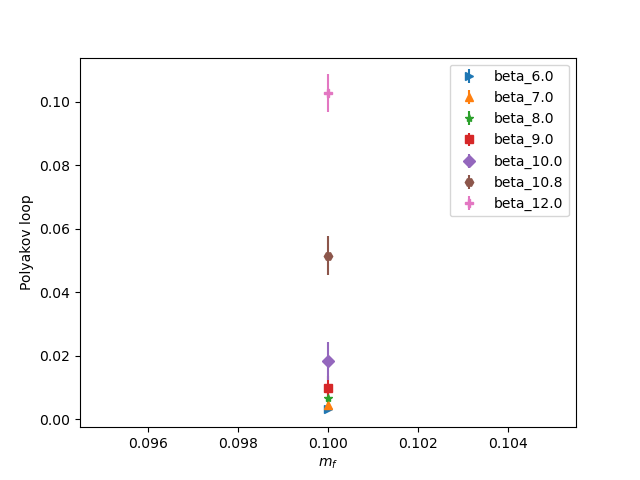

Text(0, 0.5, 'Polyakov loop')

In [13]:
plt.figure()

for beta,marker in zip(beta_list,itertools.cycle('>^*sDHPdpx_')):

    label='beta_%s'%(beta)
    df1=df_summary[df_summary.beta==beta].sort_values(by=['mf'])
#     display(df1)
    
#     if df1.shape[0]>1:
    x=df1.mf.values
    y=df1.polyakov.values
#     print(x,y)
    plt.errorbar(x,gv.mean(y),gv.sdev(y),linestyle='',label=label,marker=marker)
        

plt.xlabel(r'$m_f$')
# plt.xticks(mf_list)
# plt.xlim(-0.5,2.0)
plt.legend(loc='best')
plt.ylabel('Polyakov loop',rotation='vertical')
# plt.savefig('Ploop_vs_mf.pdf')

### Plot Polyakov loop vs $\beta$ for different $m_f$

<IPython.core.display.Javascript object>


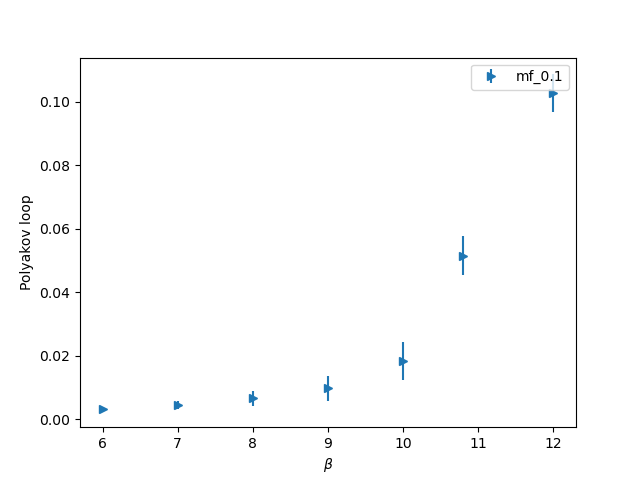

In [30]:
plt.figure()

for mf,marker in zip(mf_list,itertools.cycle('>^*sDHPdpx_')):
    label='mf_%s'%(mf)
    df1=df_summary[df_summary.mf==mf].sort_values(by=['beta'])
#     display(df1)
    
#     if df1.shape[0]>1:
    x=df1.beta.values
    y=df1.polyakov.values
#     print(x,y)
    plt.errorbar(x,gv.mean(y),gv.sdev(y),linestyle='',label=label,marker=marker)
        

plt.show()
plt.xlabel(r'$\beta$')
# plt.xticks(beta_list)
plt.legend()
plt.ylabel('Polyakov loop',rotation='vertical')
# plt.xlim(10.2,11.2)
# plt.ylim(0,0.04)
plt.savefig('Ploop_vs_beta.pdf')

### Plaquette vs beta

<IPython.core.display.Javascript object>


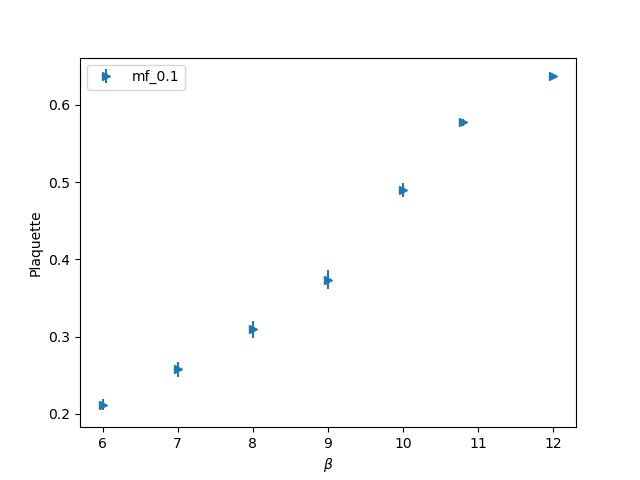

Text(0, 0.5, 'Plaquette')

In [19]:
plt.figure()

for mf,marker in zip(mf_list,itertools.cycle('>^*sDHPdpx_')):
    label='mf_%s'%(mf)
    df1=df_summary[df_summary.mf==mf].sort_values(by=['beta'])
#     display(df1)
    
#     if df1.shape[0]>1:
    x=df1.beta.values
    y=df1.plaq.values
#     print(x,y)
    plt.errorbar(x,gv.mean(y),gv.sdev(y),linestyle='',label=label,marker=marker)
        

plt.show()
plt.xlabel(r'$\beta$')
# plt.xticks(beta_list)
plt.legend()
plt.ylabel('Plaquette',rotation='vertical')
# plt.xlim(10.2,11.2)
# plt.ylim(0,0.04)
# plt.savefig('Plaq_vs_beta.pdf')

### Plot Susceptibility

<IPython.core.display.Javascript object>


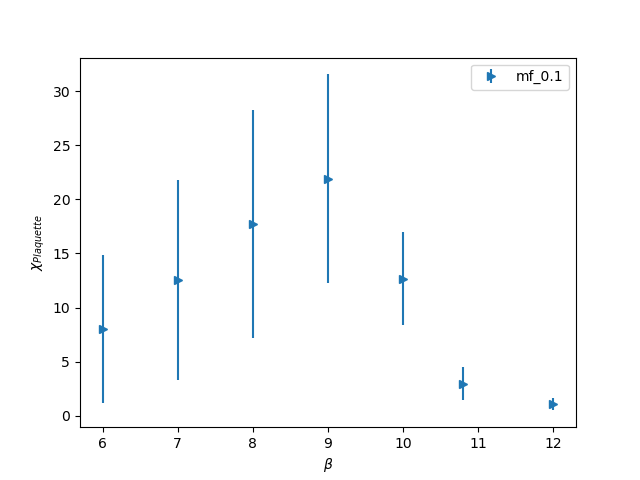

In [14]:
plt.figure()

for mf,marker in zip(mf_list,itertools.cycle('>^*sDHPdpx_')):
    label='mf_%s'%(mf)
    df1=df_summary[df_summary.mf==mf].sort_values(by=['beta'])
#     display(df1)
    
#     if df1.shape[0]>1:
    x=df1.beta.values
    y=df1.sus_plaq.values
    
#     print(x,y)
    plt.errorbar(x,gv.mean(y),gv.sdev(y),linestyle='',label=label,marker=marker)
        

plt.show()
plt.xlabel(r'$\beta$')
# plt.xticks(beta_list)
plt.legend()
plt.ylabel('$\chi_{Plaquette}$',rotation='vertical')
plt.savefig('chi_plaq_vs_beta.pdf')

<IPython.core.display.Javascript object>


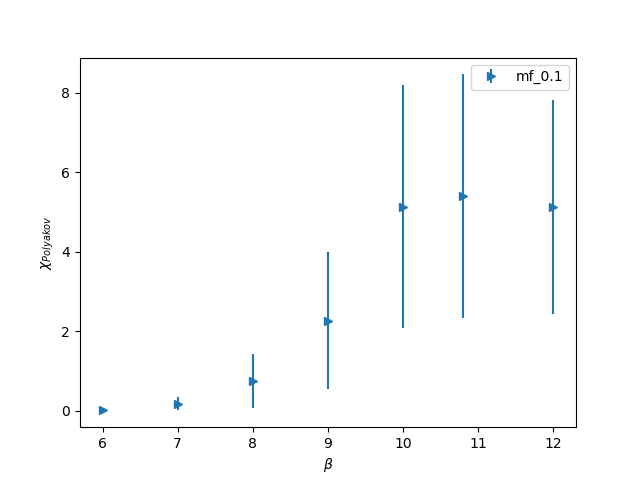

In [15]:
plt.figure()

for mf,marker in zip(mf_list,itertools.cycle('>^*sDHPdpx_')):
    label='mf_%s'%(mf)
    df1=df_summary[df_summary.mf==mf].sort_values(by=['beta'])
#     display(df1)
    
#     if df1.shape[0]>1:
    x=df1.beta.values
    y=df1.sus_poly.values
#     print(x,y)
    plt.errorbar(x,gv.mean(y),gv.sdev(y),linestyle='',label=label,marker=marker)
        

plt.show()
plt.xlabel(r'$\beta$')
# plt.xticks(beta_list)
plt.legend()
plt.ylabel('$\chi_{Polyakov}$',rotation='vertical')
plt.savefig('chi_poly_vs_beta.pdf')

<IPython.core.display.Javascript object>


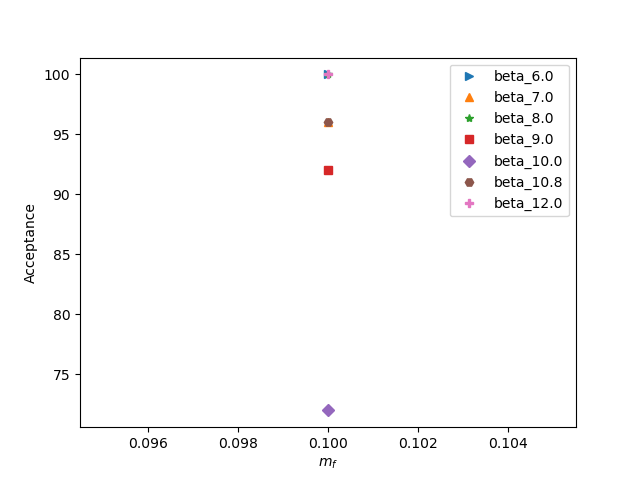

Text(0, 0.5, 'Acceptance')

In [16]:
# Plot acceptance rate 

plt.figure()

for beta,marker in zip(beta_list,itertools.cycle('>^*sDHPdpx_')):

    label='beta_%s'%(beta)
    df1=df_summary[df_summary.beta==beta].sort_values(by=['mf'])
#     display(df1)
    
#     if df1.shape[0]>1:
    x=df1.mf.values
    y=df1.accept.values
#     print(x,y)
    plt.plot(x,y,linestyle='',label=label,marker=marker)
#     plt.errorbar(x,gv.mean(y),gv.sdev(y),linestyle='',label=label,marker=marker)
        

plt.xlabel(r'$m_f$')
# plt.xticks(mf_list)
# plt.xlim(-0.5,2.0)
plt.legend(loc='best')
plt.ylabel('Acceptance',rotation='vertical')
# plt.savefig('Acceptance_vs_mf.pdf')

In [20]:
df1

,beta,mf,Lx,Lt,Ls,plaq,sus_plaq,kurt_plaq,polyakov,sus_poly,kurt_poly,traj_time,accept
4,12.0,0.1,16,8,16,0.6368(27),1.06(56),6.3(5.1)e-07,0.1027(60),5.1(2.7),6.2(5.3)e-07,71.46(41),100.0


## Individual plots

In [21]:
data_dict.keys()

dict_keys(['beta-10.0_mf-0.1_Lx-16_Lt-8_Ls-16', 'beta-10.8_mf-0.1_Lx-16_Lt-8_Ls-16', 'beta-12.0_mf-0.1_Lx-16_Lt-8_Ls-16', 'beta-8.0_mf-0.1_Lx-16_Lt-8_Ls-16', 'beta-9.0_mf-0.1_Lx-16_Lt-8_Ls-16', 'beta-6.0_mf-0.1_Lx-16_Lt-8_Ls-16', 'beta-7.0_mf-0.1_Lx-16_Lt-8_Ls-16'])

<IPython.core.display.Javascript object>


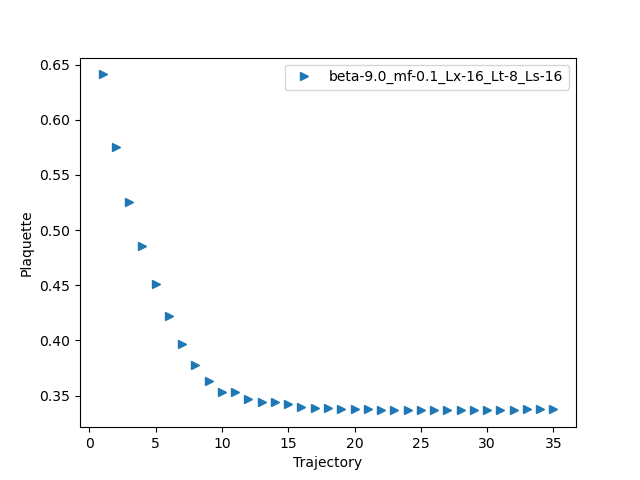

beta-9.0_mf-0.1_Lx-16_Lt-8_Ls-16


<IPython.core.display.Javascript object>


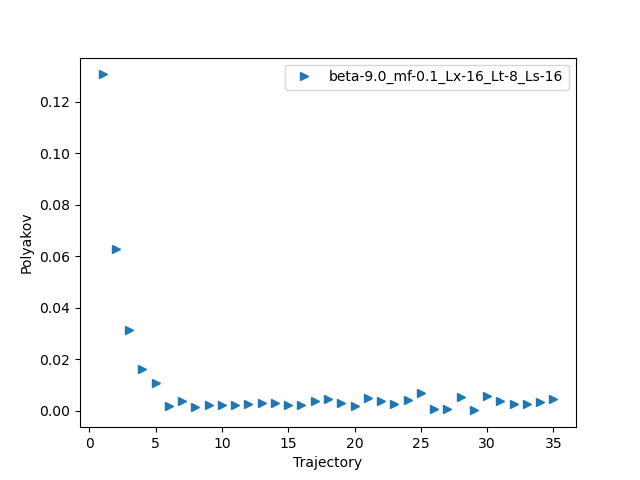

beta-9.0_mf-0.1_Lx-16_Lt-8_Ls-16


In [34]:

def f_plot_specific_runs(data_dict,column,keys_list):
    ''' Plot behavior of quantity in MC time
    col = Plaquette, Polyakov, Traj_time, Accept, Plaq_epoch'''
    
    assert len(keys_list)>0 ,"Shortened list has 0 elements" 
    
    plt.figure()

    for i,marker in zip(keys_list,itertools.cycle('>^*sDHPdpx_')):

        df=data_dict[i]
        label=i
        print(label)
        x=df.iter.values
        if column=='Polyakov':
            y=np.abs(df[column].values)
        else:
            y=df[column].values

        plt.plot(x,y,linestyle='',label=label, marker=marker)

    plt.legend(loc='best')
    plt.ylabel(column)
    plt.xlabel('Trajectory')
    plt.show()
    
    
beta_list=[9.0]
mf_list=[0.1]
## Gather dict keys with given beta and mf values
Ls=16
Lt=8
keys_list=['beta-%s_mf-%s_Lx-16_Lt-%s_Ls-%s'%(b,m,Lt,Ls) for m in mf_list for b in beta_list]

f_plot_specific_runs(data_dict,'Plaquette',keys_list)
plt.savefig('Plaq_details.pdf')

# f_plot_specific_runs(dict_list,'Traj_time',keys_list)

f_plot_specific_runs(data_dict,'Polyakov',keys_list)
plt.savefig('Polyakov_details.pdf')


<IPython.core.display.Javascript object>


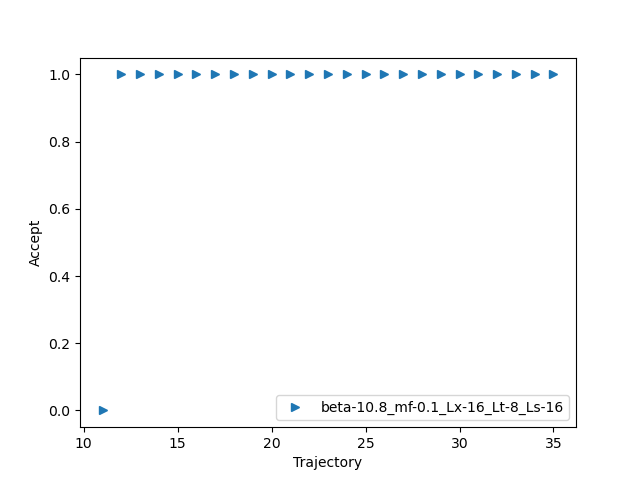

beta-10.8_mf-0.1_Lx-16_Lt-8_Ls-16


In [23]:
f_plot_specific_runs(data_dict,'Accept',keys_list)


### Plot Polyakov loop

In [37]:
# fig=plt.figure()

# for i in dict_list:
#     df=i['df']
#     label=i['beta']+'_'+i['mf']
# #     print(label)
    
    
#     x=df.iter.values
#     y=df.Polyakov.values
#     fig.add_subplot(2,1,1)

#     plt.plot(x,y.real,marker='o',linestyle='',label=label)
#     plt.ylabel('Real Polyakov loop')

#     fig.add_subplot(2,1,2)

#     plt.plot(x,y.imag,marker='o',linestyle='',label=label)
    
# plt.legend(loc='best')
# plt.ylabel('Imag Polyakov loop')
# plt.show()


In [25]:
data_dict.keys()

dict_keys(['beta-10.0_mf-0.1_Lx-16_Lt-8_Ls-16', 'beta-10.8_mf-0.1_Lx-16_Lt-8_Ls-16', 'beta-12.0_mf-0.1_Lx-16_Lt-8_Ls-16', 'beta-8.0_mf-0.1_Lx-16_Lt-8_Ls-16', 'beta-9.0_mf-0.1_Lx-16_Lt-8_Ls-16', 'beta-6.0_mf-0.1_Lx-16_Lt-8_Ls-16', 'beta-7.0_mf-0.1_Lx-16_Lt-8_Ls-16'])

In [26]:
keys_list

['beta-10.8_mf-0.1_Lx-16_Lt-32_Ls-16']

<IPython.core.display.Javascript object>


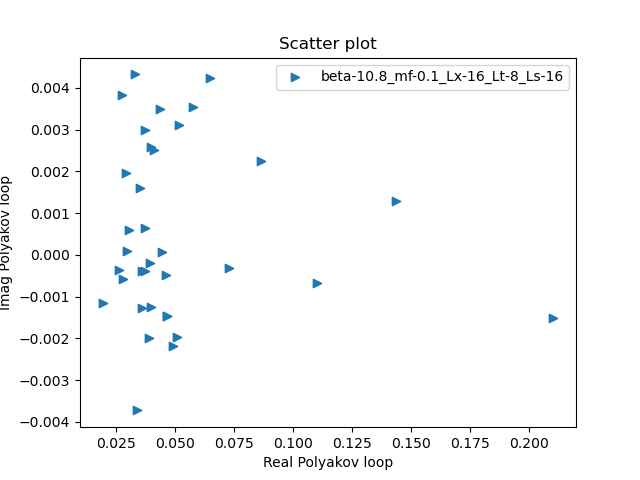

beta-10.8_mf-0.1_Lx-16_Lt-8_Ls-16


In [28]:
keys_list=['beta-%s_mf-%s_Lx-16_Lt-8_Ls-16'%(b,m) for m in mf_list for b in beta_list]


fig=plt.figure()

for i,marker in zip(keys_list,itertools.cycle('>^*sDHPdpx_')):
    df=data_dict[i]
    label=i
    print(label)

    x=df.iter.values
    y=df.Polyakov.values

    y1=y.real
    y2=y.imag

    plt.scatter(y1,y2,label=label,marker=marker)
    
plt.legend(loc='best')
plt.xlabel('Real Polyakov loop')
plt.ylabel('Imag Polyakov loop')
plt.title("Scatter plot")
plt.show()

<IPython.core.display.Javascript object>


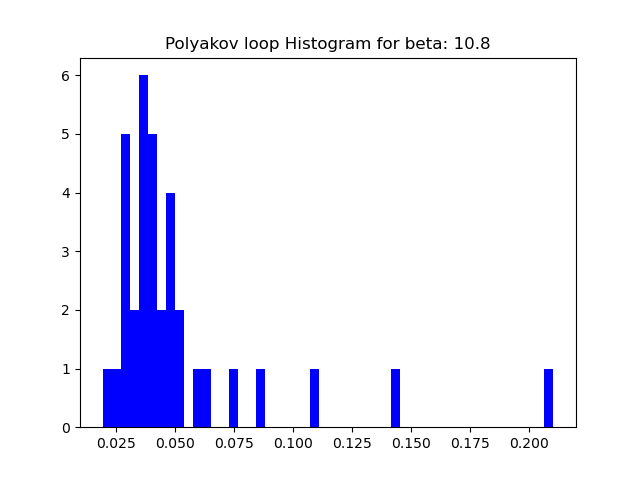

In [29]:
# Histogram
beta=10.8
mf=0.1
key='beta-%s_mf-%s_Lx-16_Lt-8_Ls-16'%(beta,mf)

df=data_dict[key]

fig=plt.figure()
x=df.iter.values[:210]
y=np.abs(df.Polyakov.values[:210])

# hist,bins=np.histogram(y,bins=10)
# plt.bar(np.linspace(0,0.3,10),hist)
# plt.stairs(hist)

plt.hist(y,bins=50,color='b')

plt.title("Polyakov loop Histogram for beta: %s"%(beta))
plt.savefig('ploop_histogram.pdf')